# Backtesting Sentiment Pairs

<b>Summary: </b>
<br>
For rolling average and rolling standard deviation of the lenght 7 days, NLP was calcualted for all possible combinations. A trading fee was assumed 0.0075 (taken from Bitmex). Calculations show that the best pairs are Bots/Whitepaper, Announcement/Bearish, Shilling/Team, and FOMO/Whales. Not surprisingly, increasing fees and window sizes changes to outcome of top performing pairs of topics.
<br>
Furthermore, NLP of the top performers was plotted on with different windows values (up to 30). It's interesting to see that for some pairs, 7 days for rolling mean and standard deviation is not an optimal window. For example, for whales/FOMO, a window of 24 yields a much higher PNL.
<br>
Finally a heat map for various moving standard deviation and average windows sizes shows that an optimal value is concentrated within a specific area.
<br>
In conclusion, due to a very high amount of combinations of windows sizes and sentiment tags, finding the "best" pair is hard. Every pair will have its highest NLP concentrated in different areas. Changing a size of one of the windows might change results drastically.

In [1]:
import sys
sys.path.insert(0, "../src")
import example_helper as eh
import analysis_helper as ah
import msgpack
import zlib
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns; sns.set()

# Get Data

In [2]:
# define the location of the input file
filename_augmento_topics = "../data/example_data/augmento_topics.msgpack.zlib"
filename_augmento_data = "../data/example_data/augmento_data.msgpack.zlib"
filename_bitmex_data = "../data/example_data/bitmex_data.msgpack.zlib"

# load the example data
all_data = eh.load_example_data(filename_augmento_topics,
                             filename_augmento_data,
                             filename_bitmex_data)
aug_topics, aug_topics_inv, t_aug_data, aug_data, t_price_data, price_data = all_data
all_topics = aug_data.T.astype(float)

# calculate PNL for a given strategy
# if sentiment positive go long, else go short
# fees are assumed to be 0.75% (taker fee from BITMEX)

def strategy(price_data, signal_a, signal_b, window_1 = 24 * 7, window_2 = 24*7,buy_sell_fee = 0.0075, pnl_0 = 1.0):    
    sent_score = ah.nb_calc_sentiment_score_a(signal_a,signal_b,window_1,window_2)
    pnl = ah.nb_backtest_a(price_data, sent_score, 1.0, buy_sell_fee)
    return pnl

# PNL of various moving window size for a given combination of topics
def window_combination(price_data,top_a,top_b,end_day_x,end_day_y,start_day_x=0,start_day_y=0,buy_sell_fee=0.0075):
    total_comb = np.zeros(shape=(end_day_x,end_day_y))
    print("Calculating...")
    for i in range(start_day_x,end_day_x):
        for j in range(start_day_y,end_day_y):
            total_comb[i][j] = strategy(price_data,top_a,top_b,window_1=24*(i+1),window_2=24*(j+1),buy_sell_fee = 0.0075)[-1]
    print("Done.")
    return total_comb[start_day_x:end_day_x,start_day_y:end_day_y]
    

### Given window size 7 in rolling average and standard deviation, calculate PNL for every possible pair of strategies.
It will give 8649 NLP values calculated from 2017 until the beginning of 2019

In [3]:
# for each combination of signals, generate PNL for the last period in data
total = np.zeros(shape=(93,93))
print("calculating... might take a minute or two...")
for i in range(0,len(all_topics)):
    for j in range(0,len(all_topics)):
        sent_score = ah.nb_calc_sentiment_score_a(all_topics[i],all_topics[j],ra_win_size=24*7,std_win_size=24*7)
        pnl = ah.nb_backtest_a(price_data, sent_score, 1.0, buy_sell_fee=0.0075)
        total[i][j] = pnl[-1]
    #print("Row " + str(i+1) + " out of 93...")
print("done")

calculating... might take a minute or two...
done


### Impossible to see all 8649 values
Chose top 30

In [4]:
# get all PNL in a dataframe
data = pd.DataFrame(total).rename(columns=aug_topics,index=aug_topics)
# given all combinations of signals, show the combinations that yield the highest PNL
c = data.abs()
s = c.unstack()
so_st = s.sort_values(kind="quicksort")
# specify n, a number of top combinations to be shown
t = so_st.tail(n=30).index

# labels for graphs and tables
columns_t = dict((y, x) for x, y in t).keys()
rows_t = dict((x, y) for x, y in t).keys()

# pick from the dataframes only the pairs of strategies that are within the top list
top = data[rows_t].loc[columns_t]

In [5]:
so_st.head(n=20)

Investing/Trading      Bearish                0.000422
(De-)centralisation    Price                  0.000424
Positive               Selling                0.000434
Learning               Bearish                0.000571
Advice/Support         Bearish                0.000692
Euphoric/Excited       Long_term_investing    0.000718
Technical_analysis     Short_term_trading     0.000743
Problems_and_issues    Short_term_trading     0.000836
Learning               Good_news              0.000877
Euphoric/Excited       Short_term_trading     0.000885
Scam/Fraud             Token_economics        0.000941
Listing                Token_economics        0.000953
Problems_and_issues    Due_diligence          0.000978
Positive               Hopeful                0.001021
Problems_and_issues    Fearful/Concerned      0.001069
Use_case/Applications  Short_term_trading     0.001078
Prediction             Going_short            0.001093
Uncertain              Short_term_trading     0.001124
Technology

# Heat Map for top 30 pairs

In [6]:
# a sorted dataframe to get highest PNLs in the first rows
idx = pd.unique([i[1] for i in np.flip(t.values)])
col = pd.unique([i[0] for i in np.flip(t.values)])
sorted_df = data[col].loc[idx]

### Taking best pairs, plot NLP
Heatmap helps to visualilze results

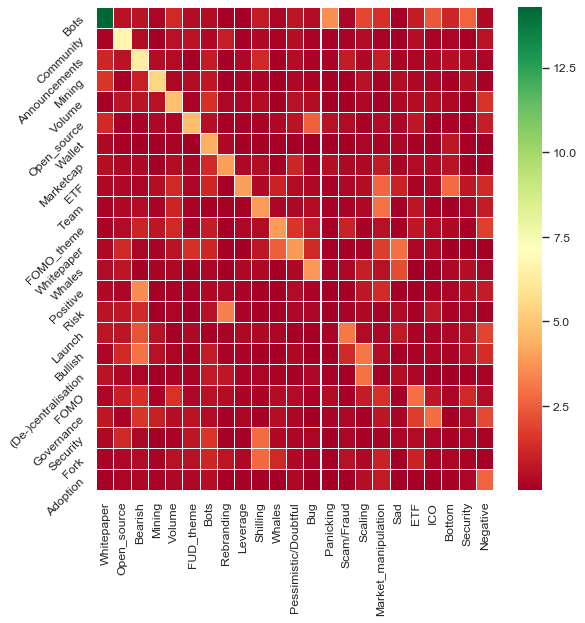

In [7]:
# plot a heat map with top 30 PNLs
# light colors indicate high, while dark colors low values
m = np.array(sorted_df)
figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(m, linewidth=0.01, cmap="RdYlGn")
ax.set_xticklabels(col, rotation=90)
ax.set_yticklabels(idx, rotation = 45)
plt.show()

# Testing for different windows sizes

### Before the backtesting was for only one window size. It's also interesting to see how the strategy would work with different windows sizes

In [8]:
# recompute the NLP matrix for the above found combinations for window sizes from 1 to number of days specified
number_of_days = 30
top_n = 20
t_10 = so_st.tail(n=top_n).index
empty = np.zeros([top_n, number_of_days])
for j in range(len(t_10)):
    for days in range(1,(number_of_days+1)):    
        a = strategy(price_data,all_topics[aug_topics_inv[t_10[j][1]]],all_topics[aug_topics_inv[t_10[j][0]]],window_1=24*days,window_2=24*days)[-1]
        empty[j][days-1] = a

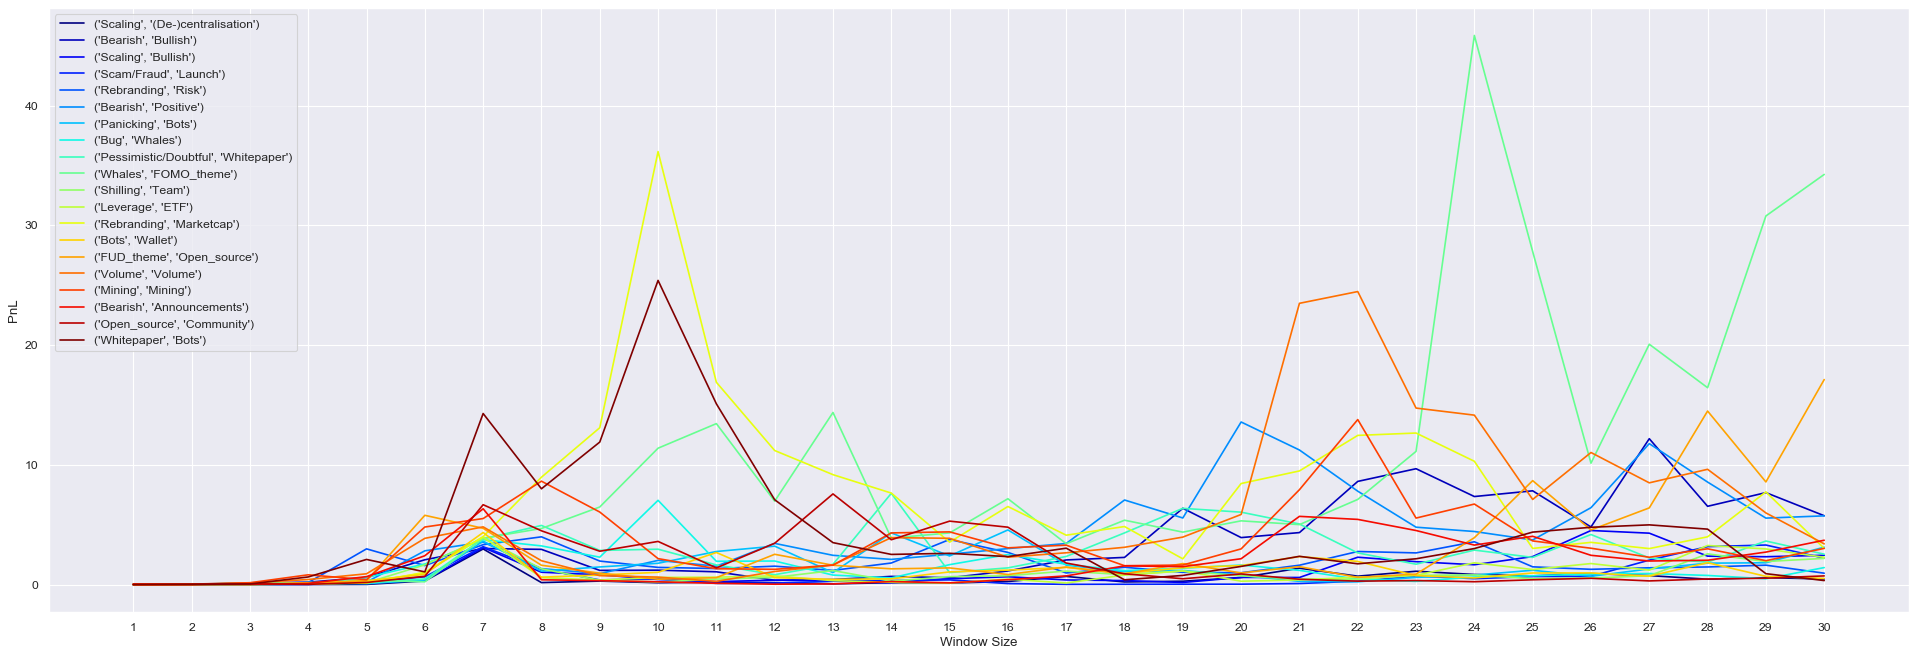

In [9]:
# plot combinations for different window sizes
figure(num=None, figsize=(30, 10), dpi=80)
days_a = np.arange(number_of_days)
labels = t_10.values
cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0, 1.0,20))
ax = plt.gca()
for i , label, color in zip(empty,labels,colors):
    plt.plot(days_a,i,label=label,color=color)
    plt.xticks(np.arange(number_of_days), np.arange(1,number_of_days+1))
    plt.legend()
    plt.xlabel("Window Size")
    plt.ylabel("PnL")



# Different rolling mean and std window sizes

From a chosen pair of topics, compute NLP for various rolling average and rolling std. It's interesting to see, whether the "optimal" values are concentrated withing a specific range.

### Example for 'Bots' and 'Whitepaper'

In [10]:
#specify tags
ix = 0 # specify startpoint number of rolling mean
iy = 10 # specify startpoint of rolling std
end_x = 20 # specify endpoint number of rolling mean
end_y = 30 # specify endpoint of rolling std
topic_a = 'Bots'
topic_b = 'Whitepaper'
top_b = all_topics[aug_topics_inv[topic_b]]
top_a = all_topics[aug_topics_inv[topic_a]]
total_s = window_combination(price_data,top_a,top_b,end_x,end_y,start_day_x=ix,start_day_y=iy)

Calculating...
Done.


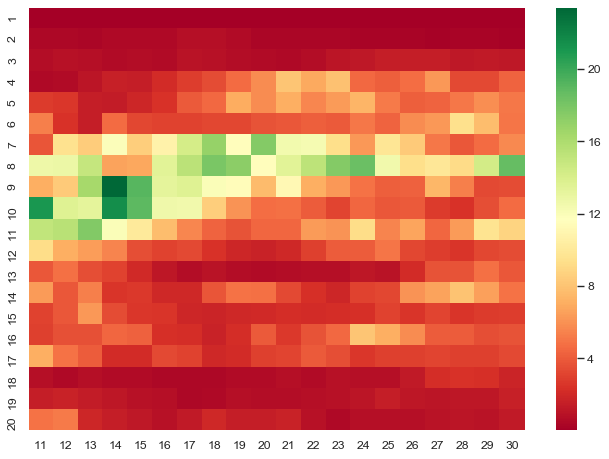

In [11]:
# plot
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.0, dark=1.2, as_cmap=True)
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(total_s, linewidth=0.00, cmap="RdYlGn",yticklabels=np.arange(ix+1,end_x+1),xticklabels=np.arange(iy+1,end_y+1))
plt.show()

#### example for 'Positive' and 'Bearish'

In [12]:
#specify tags
ix = 0
iy = 0
end_x = 60
end_y = 60
topic_a = 'Positive'
topic_b = 'Bearish'
top_b = all_topics[aug_topics_inv[topic_b]]
top_a = all_topics[aug_topics_inv[topic_a]]
total_s = window_combination(price_data,top_a,top_b,end_x,end_y,start_day_x=ix,start_day_y=iy)

Calculating...
Done.


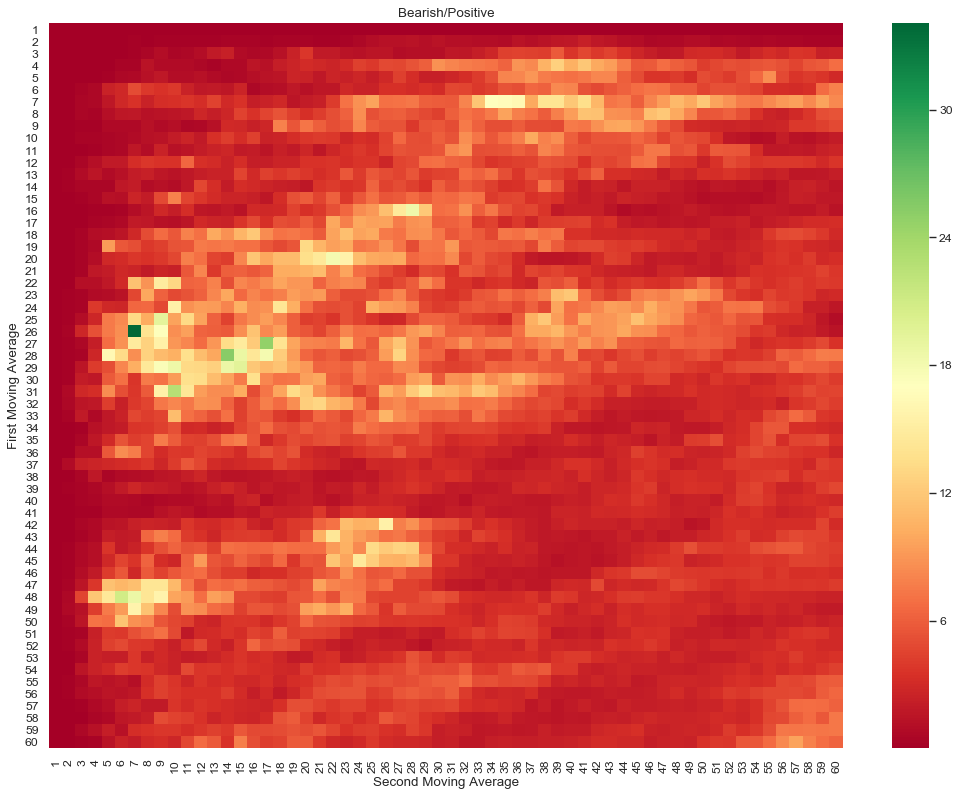

In [13]:
# plot

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='black')
ax = sns.heatmap(total_s, linewidth=0.00, cmap="RdYlGn",yticklabels=np.arange(ix+1,end_x+1),xticklabels=np.arange(iy+1,end_y+1))
ax.set_title('Bearish/Positive')
ax.set_ylabel('First Moving Average')
ax.set_xlabel('Second Moving Average')
plt.show()

### Plotted 4 points

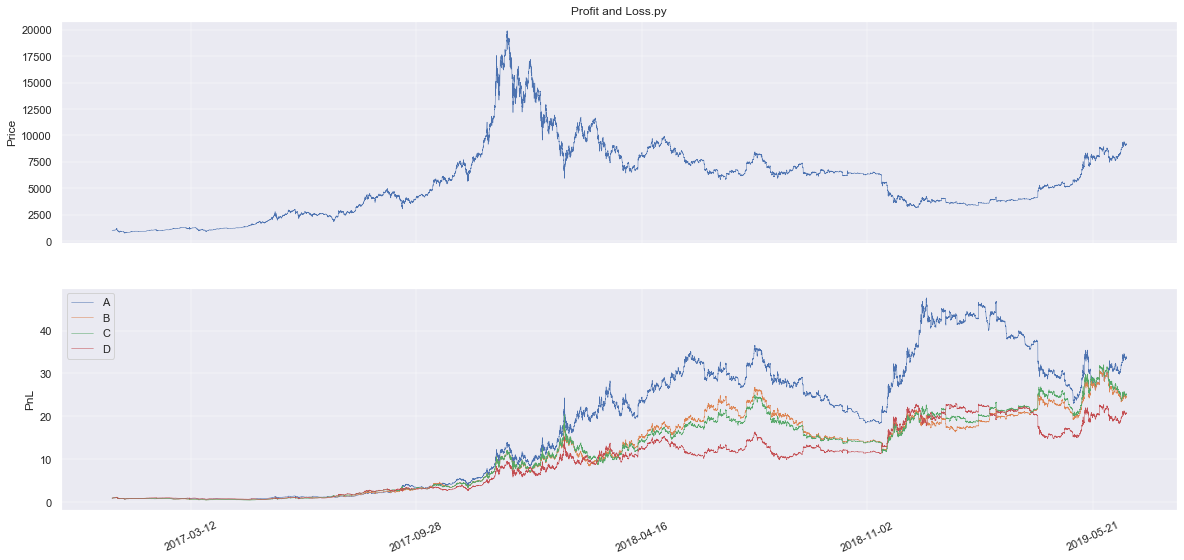

In [14]:
# Pick Topics
aug_signal_a = aug_data[:, aug_topics_inv["Positive"]].astype(np.float64)
aug_signal_b = aug_data[:, aug_topics_inv["Bearish"]].astype(np.float64)

# generate the sentiment score
sent_score = ah.nb_calc_sentiment_score_a(aug_signal_a, aug_signal_b, 26*24, 7*24)
sent_score1 = ah.nb_calc_sentiment_score_a(aug_signal_a, aug_signal_b, 27*24, 17*24)
sent_score2 = ah.nb_calc_sentiment_score_a(aug_signal_a, aug_signal_b, 28*24, 14*24)
sent_score3 = ah.nb_calc_sentiment_score_a(aug_signal_a, aug_signal_b, 48*24, 6*24)

# define some parameters for the backtest
start_pnl = 1.0
buy_sell_fee = 0.0075

# run the backtest
pnl = ah.nb_backtest_a(price_data, sent_score, start_pnl, buy_sell_fee)
pnl1 = ah.nb_backtest_a(price_data, sent_score1, start_pnl, buy_sell_fee)
pnl2 = ah.nb_backtest_a(price_data, sent_score2, start_pnl, buy_sell_fee)
pnl3 = ah.nb_backtest_a(price_data, sent_score3, start_pnl, buy_sell_fee)

# set up the figure
fig, ax = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(20,10))

# initialise some labels for the plot
datenum_aug_data = [md.date2num(datetime.datetime.fromtimestamp(el)) for el in t_aug_data]
datenum_price_data = [md.date2num(datetime.datetime.fromtimestamp(el)) for el in t_price_data]

# plot stuff
ax[0].grid(linewidth=0.4)
ax[1].grid(linewidth=0.4)

ax[0].plot(datenum_price_data, price_data, linewidth=0.5)

ax[1].plot(datenum_aug_data, pnl, linewidth=0.5)
ax[1].plot(datenum_price_data, pnl1, linewidth=0.5)
ax[1].plot(datenum_price_data, pnl2, linewidth=0.5)
ax[1].plot(datenum_price_data, pnl3, linewidth=0.5)
ax[1].legend(("A","B","C","D"))


# label axes
ax[0].set_ylabel("Price")
ax[1].set_ylabel("PnL")
ax[0].set_title("Profit and Loss.py")

# generate the time axes
plt.subplots_adjust(bottom=0.2)
plt.xticks( rotation=25 )
ax[0]=plt.gca()
xfmt = md.DateFormatter('%Y-%m-%d')
ax[0].xaxis.set_major_formatter(xfmt)



# show the plot
plt.show()